# How You Develop Your Trading Strategies Matters, a Lot!

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 999

We can easily create random looking-distributions

In [2]:
prices = 100 + np.cumsum(np.random.normal(size=365*3))

if False:
    with open('prices.npy', 'wb') as f:
        np.save(f, prices)

Let's load one we've already created, to be on the same page

In [3]:
with open('prices.npy', 'rb') as f:
    prices = np.load(f)

Looks like pricing data, doesn't it?

Text(0,0.5,'Price (USD)')

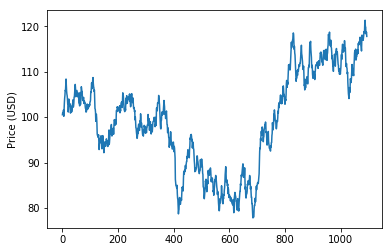

In [4]:
plt.plot(prices)
plt.ylabel('Price (USD)')

Here we develop a generic training strategy based on moving average crosssovers. It's [a very well known strategy](https://www.investopedia.com/university/movingaverage/movingaverages4.asp). It has two arguments, the length of the slow and the fast moving average. The function `sim_strategy()` below, gives you the profit and the total capital requirements when you run the moving average crosssover strategy on a timeseries `prices`.

In [5]:
class ConditionLatch(object):
    def __init__(self):
        self.last_value = False

    def __call__(self, condition):
        transition = (not self.last_value) and condition
        self.last_value = condition
        return transition


class Ma(object):
    def __init__(self, ma_size):
        self.alpha = 2. / (ma_size + 1)
        self.value = 0

    def __call__(self, p):
        self.value = (1. - self.alpha) * self.value + self.alpha * p
        return self.value


def sim_strategy(prices,
                 ma_slow_size,
                 ma_fast_size,
                 callback=lambda mslow, mfast, capital: None,
                 units_to_trade=100):

    assert ma_slow_size > ma_fast_size

    invested_capital = 0
    max_invested = 0
    profit = 0

    slow, fast = Ma(ma_slow_size), Ma(ma_fast_size)
    buy_condition, sell_condition = ConditionLatch(), ConditionLatch()

    for i, p in enumerate(prices):

        ma_slow = slow(p)
        ma_fast = fast(p)

        if i <= ma_slow_size:  # Don't trade till MAs are fully ready
            callback(ma_slow, ma_fast, 0.)
            continue

        buy_signal = buy_condition(ma_fast > ma_slow)
        sell_signal = sell_condition(ma_fast < ma_slow)
        
        assert not (buy_signal and sell_signal)  # Sanity check

        if i == (len(prices) - 1):
            # Last trade is always a sell, to liqudate the portfolio
            buy_signal = False
            sell_signal = True

        if buy_signal and (not invested_capital):
            invested_capital = p * units_to_trade
            max_invested = max(max_invested, invested_capital)
        elif sell_signal and invested_capital:
            profit += (p * units_to_trade) - invested_capital
            invested_capital = 0

        callback(ma_slow, ma_fast, invested_capital)

    return profit, max_invested

## Backtester's delight

Below is a naïve, p-hacking optimization technique. We scan all the valid combinations for window sizes up to `MAX_SLOW`.

In [6]:
MAX_SLOW = 10

uniform_data = np.full((MAX_SLOW, MAX_SLOW), np.NaN)
columns = ['slow', 'fast', 'profit', 'roi']
d = []

for slow in range(1, MAX_SLOW):
    for fast in range(1, slow):
        profit, max_invested = sim_strategy(prices, slow, fast)
        d.append([slow, fast, profit, 100 * profit / max_invested])

        uniform_data[fast][slow] = profit

df = pd.DataFrame(data=d, columns=columns)
df.sort_values(by='profit', ascending=False)

,slow,fast,profit,roi
2,3,2,5646.235068,47.864757
3,4,1,4983.248719,42.455747
4,4,2,4949.488039,42.168116
0,2,1,4484.832658,37.782872
6,5,1,4413.462995,37.601348
7,5,2,4233.551309,36.068556
10,6,1,4019.543338,34.245273
5,4,3,4016.871478,34.405001
1,3,1,3971.950147,33.462047
8,5,3,3924.467126,33.243228


The associated payouts can be seen on the following diagram:

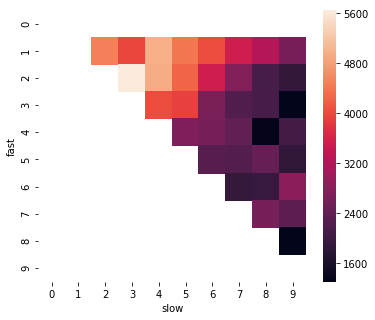

In [7]:
plt.rcParams['figure.figsize'] = [6, 5]
ax = sns.heatmap(uniform_data)

r = ax.set(xlabel='slow', ylabel='fast')

Based on the above, we chose the optimum sizes slow = 3 and fast = 2. Let's see what trades this strategy gives:

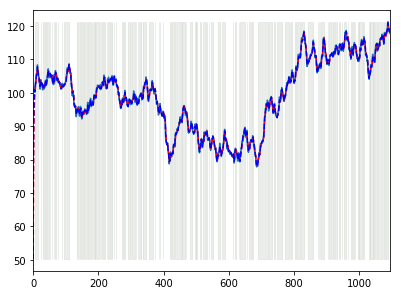

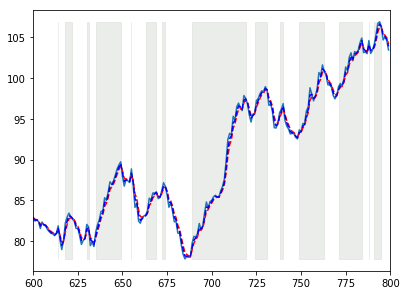

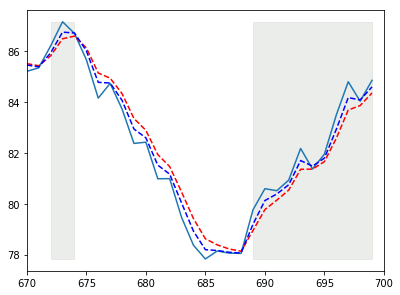

In [8]:
def plot(prices, slow, fast, start=None, srange=None):
    start=0 if start is None else start
    srange=len(prices) if srange is None else srange
    
    mslow, mfast, capital = [], [], []

    def capture(mslow_, mfast_, capital_):
        mslow.append(mslow_)
        mfast.append(mfast_)
        capital.append(capital_)

    sim_strategy(prices, slow, fast, capture)

    capital = np.array(capital)

    prices = prices[start:start + srange]
    mslow = mslow[start:start + srange]
    mfast = mfast[start:start + srange]
    capital = capital[start:start + srange]

    fig, ax = plt.subplots()

    x = list(range(start, start + srange))

    plt.xlim([start, start + srange])

    plt.plot(x, prices)
    plt.plot(x, mslow, 'r--')
    plt.plot(x, mfast, 'b--')

    ax.fill_between(x,
                    np.min([prices, mslow, mfast]),
                    np.max([prices, mslow, mfast]),
                    where=capital > 0,
                    color=sns.xkcd_rgb['light grey'],
                    alpha=0.5)

plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.figsize'] = [6.4, 4.8]

plot(prices, 3, 2)

plot(prices, 3, 2, 600, 200)

plot(prices, 3, 2, 670, 30)

It looks spectacular. But is it? Let's see how well it does on other out-of-sample random-walks:

-16.89083888623593

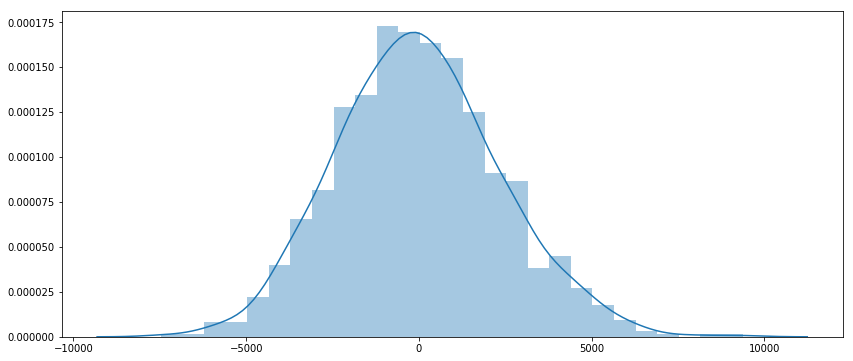

In [9]:
def eval_random_walks(strategy, f=lambda i:i):
    total_profit = [strategy(f(100 +
                               np.cumsum(np.random.normal(size=365*3))))[0]
                    for i in range(1000)]

    plt.rcParams['figure.figsize'] = [14, 6]
    sns.distplot(total_profit)

    return np.average(total_profit)

eval_random_walks(lambda prices: sim_strategy(prices, 3, 2))

Well... it's trash! Note also that the average profit is quite unstable. Each run might give positive or negative profit. You should never trade with this strategy despite the fact that it looks great while backtesting.

Note: This should be expected since the strategy was build based on random date. Anyone who gives you, with confidence, winner strategies derived from random data, doesn't know what they're talking about. **The backtesting-based methodology above, gives strategies, but doesn't provide us with a way to evaluate their effectiveness.**

## A sound methodology

We split the timeseries into a number of `segments`. We shuffle them and pick 20% of them as test data and the rest as training data. We use test data only for evaluation. Our naïve optimization technique optimizes only over training data.

In [10]:
from sklearn.model_selection import train_test_split

def train_and_test(prices, segments, random_state=5):
    segment_size = prices.shape[0] // segments

    X = (prices[:(segment_size * segments)]
         .reshape(segments, segment_size))

    X_train, X_test = train_test_split(X,
                                       test_size=0.20,
                                       random_state=random_state)

    def average_profit(slow, fast, sequences):
        return (sum(sim_strategy(p, slow, fast)[0] for p in sequences)
                / sequences.shape[0])

    # Train
    MAX_SLOW = 10
    performance = [(slow, fast, average_profit(slow, fast, X_train))
                   for slow in range(1, MAX_SLOW)
                   for fast in range(1, slow)]

    best = sorted(performance, key=lambda row: -row[2])[0]

    # Evaluate
    slow, fast, p0 = best

    profits = [sim_strategy(subseq, slow, fast)[0]
               for subseq in X_test]
    sns.distplot(profits)

    return best, profits

Let's run and see the distribution of profits.

((2, 1, 125.86939637292008), -3.525631036089635)

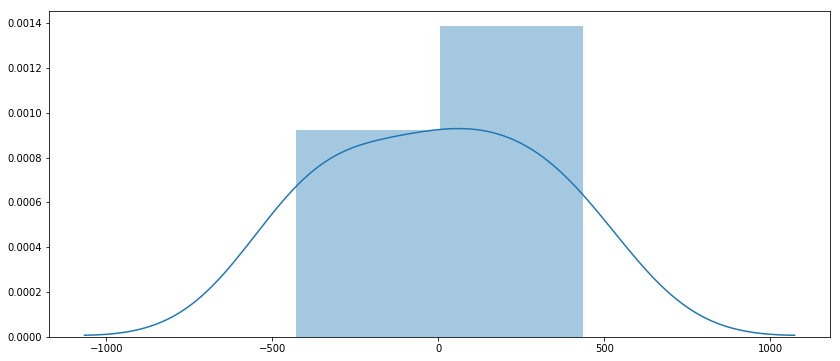

In [11]:
best, profits = train_and_test(prices, segments=50)
best, np.average(profits)

Fantastic. Now as part of our development methodology, we can see that the expected result is zero! We know it's zero, since our data-driven methodology was driven by random data. Now we won't try to defend this strategy. It is trash and we know it on development time, since our "backtesting" is done on a different set to the one we optimized for. **We can now proactivelly tell good from bad strategies apart**

## Can it find winning strategies?

Sure! As long as data has patterns of the algorithm's caliber. Let's add a slight autocorrelation pattern on our original timeseries.

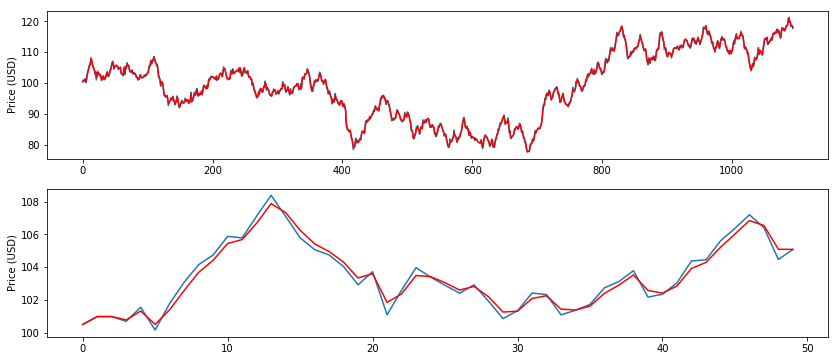

In [12]:
def patternize(prices, ac=0.3):
    prices_with_pattern = np.copy(prices)
    for i, p in enumerate(prices_with_pattern):
        if i > 1:
            prices_with_pattern[i] = (ac * prices_with_pattern[i - 1] +
                                      (1 - ac) * prices_with_pattern[i])
    return prices_with_pattern

prices_with_pattern = patternize(prices)

f, ax = plt.subplots(2)

ax[0].plot(prices)
ax[0].plot(prices_with_pattern, 'r')
ax[0].set_ylabel('Price (USD)')

ax[1].plot(prices[:50])
ax[1].plot(prices_with_pattern[:50], 'r')
ax[1].set_ylabel('Price (USD)')

None

Small change, but our moving average strategy should be able to exploit it.

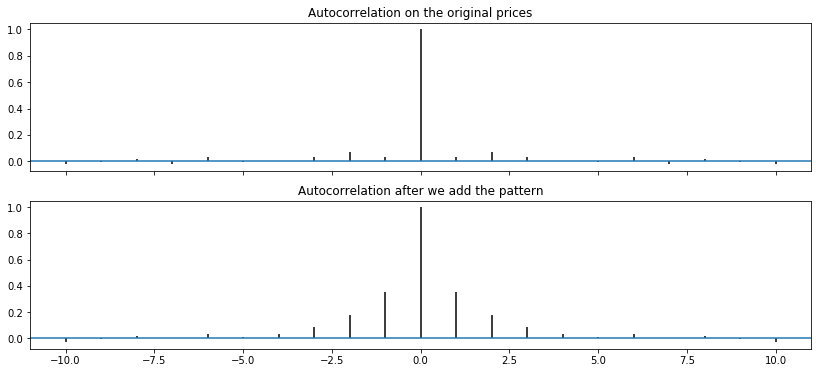

In [13]:
f, ax = plt.subplots(2, sharex=True)
ax[0].set_title('Autocorrelation on the original prices')
ax[0].acorr([i - j for i, j in zip(prices, prices[1:])])
ax[1].set_title('Autocorrelation after we add the pattern')
ax[1].acorr([i - j for i, j in zip(prices_with_pattern, prices_with_pattern[1:])])
None

Let's follow the same methodology now that we have this pattern.

((2, 1, 234.66832986912974), 117.06263687998862)

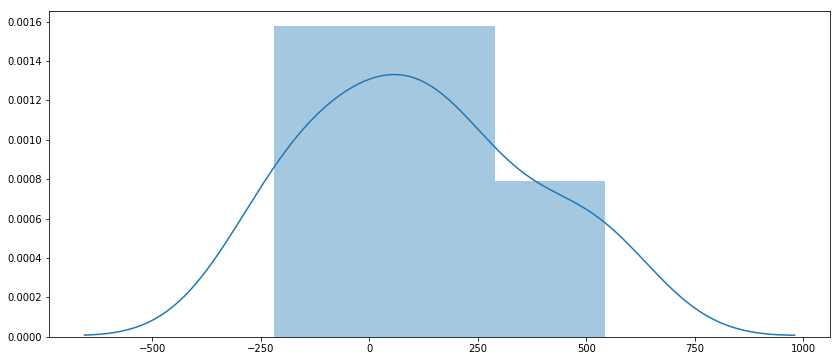

In [14]:
best, profits = train_and_test(prices_with_pattern, segments=50)
best, np.average(profits)

This looks great! Note also that even if you run many times with other segmentations, by using `random_state=None` in `train_and_test()`, you will get gains most of the times. How much ROI can we expect?

In [15]:
a , b = sim_strategy(prices_with_pattern, 2, 1)
print("{:}%".format(int((100 * a) / b)))

107%


Wow! I want that! But are we right? Do we still overfit? Let's use `eval_random_walks()` to try to many random walks to which we apply them the pattern with `patternize`.

8969.253809871438

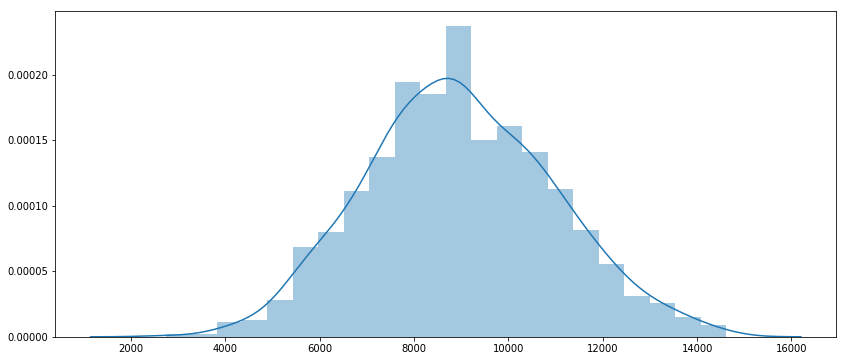

In [16]:
slow, fast, p0 = best
eval_random_walks(lambda prices: sim_strategy(prices, slow, fast),
                  patternize)

This looks real! The trading strategy makes profit. But wait. There might be a hack here. **Maybe the pattern we apply makes every algorithm profitable** e.g. enforces an up-trend. What would happen if we were trying a naive random trader?

In [17]:
def sim_strategy_dummy(prices, units_to_trade=100):

    invested_capital = 0
    max_invested = 0
    profit = 0

    for i, p in enumerate(prices):
        r = np.random.choice([1, 2, 4])
        buy_signal, sell_signal = r & 1, r & 2

        if i == (len(prices) - 1):
            # Last trade is always a sell, to liqudate the portfolio
            buy_signal = False
            sell_signal = True

        if buy_signal and (not invested_capital):
            invested_capital = p * units_to_trade
            max_invested = max(max_invested, invested_capital)
        elif sell_signal and invested_capital:
            profit += (p * units_to_trade) - invested_capital
            invested_capital = 0

    return profit, max_invested

Let's see if those patterns will make the dummy profitable...

102.55836459207704

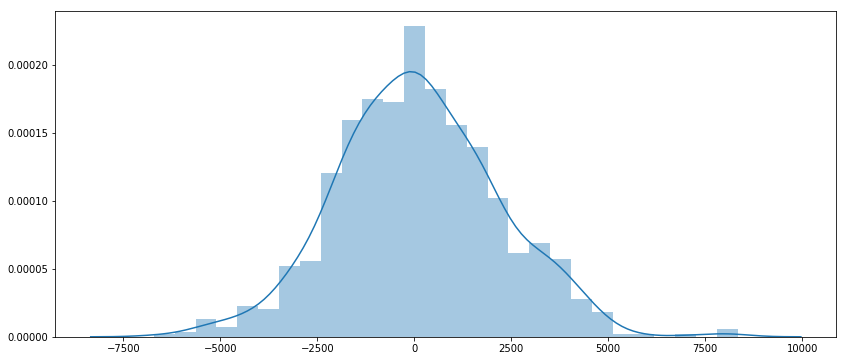

In [18]:
eval_random_walks(sim_strategy_dummy, patternize)

No, not profitable! **It's our algorithm trading the pattern that makes profit**. No algorithm or not data and we don't have profit.

By the way, our original price timeseries had an up-trend and would make even the random trader wildly profitable with about 9% profits. One more reason naïve backtesting can lead to your bankruptcy.

739.0608501057727

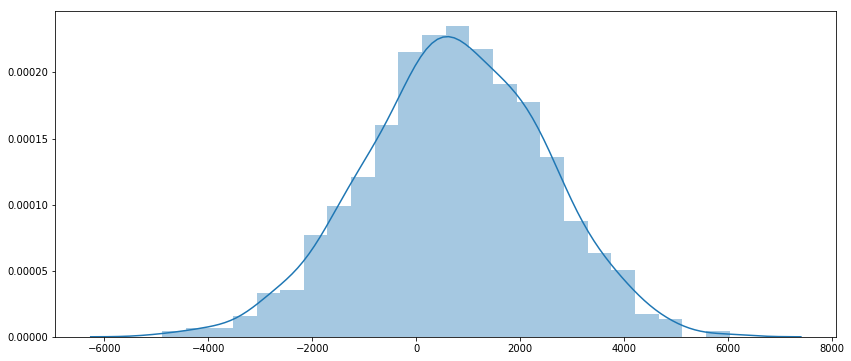

In [19]:
eval_random_walks(sim_strategy_dummy, lambda i: prices)

## Is this rocket science?

This isn't rocket science, but it's something that many traders get wrong day in and day out. You don't have to read statistician's research or go to conferences to find out about this. Even [investopedia devotes a few paragraphs on this in the definition of backtesting](https://www.investopedia.com/terms/b/backtesting.asp).

![](images/investopedia-pitfalls-of-backtesting.png)